Caso os pacotes não estejam instalado, execute a próxima célula.

In [1]:
#!pip install tensorflow
#!pip install numpy
#!pip install dill
#!pip install matplotlib
#!pip install imageio

In [2]:
import tensorflow as tf
import numpy as np
import dill
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import imageio

# Criando dados para treino

In [3]:
def amostra_sin(n):
    sub_intervalos=tf.random.uniform([n,2],0,1)
    x=tf.linspace(tf.math.reduce_min(sub_intervalos,axis=1),tf.math.reduce_max(sub_intervalos,axis=1),5,axis=1)
    return tf.math.sin(2*np.pi*x)
    
def amostra_kx(n):
    k=tf.random.uniform([n,1],-10,10)
    sub_intervalos=tf.random.uniform([n,2],tf.zeros([n,2]),tf.concat([-1/k,1/k+1/100],axis=1))
    x=tf.linspace(sub_intervalos[:,0],sub_intervalos[:,1],5,axis=1)
    return k*x
    
def amostra_kabsx(n):
    k=tf.random.uniform([n,1],-10,10)
    sub_intervalos=tf.random.uniform([n,2],tf.zeros([n,2]),tf.concat([-1/k,1/k+1/100],axis=1))
    x=tf.linspace(sub_intervalos[:,0],sub_intervalos[:,1],5,axis=1)
    return k*tf.math.abs(x)

def amostra_kxa(n):
    k=tf.random.uniform([n,1],-10,10)
    a=tf.cast(tf.random.uniform([n,1],2,6,dtype=tf.int32),dtype='float32')
    sub_intervalos=tf.random.uniform([n,2],tf.zeros([n,2]),tf.concat([-1/k,1/k+1/100],axis=1))
    x=tf.linspace(sub_intervalos[:,0],sub_intervalos[:,1],5,axis=1)
    return k*(x**a)

def amostra_slope_b(n):
    slope=tf.random.uniform([n,2],-1,1)
    x_0=tf.random.uniform([n,1],0,1)
    sub_intervalos_min=tf.random.uniform([1],tf.zeros([n,1]),x_0-1)
    sub_intervalos_max=tf.random.uniform([1],tf.zeros([n,1]),1-x_0)
    # O tf.linspace está criando uma dimensão a mais com tamanho 1
    # [:,:,0] remove esta dimensão (equivalente a tf.squeeze)
    x=tf.linspace(x_0-sub_intervalos_min,x_0-sub_intervalos_max,5,axis=1)[:,:,0] 
    return tf.where(x<x_0,slope[:,0:1],slope[:,1:2])

def amostra_const(n):
    c=tf.random.uniform([n,1],-1,1)
    return tf.repeat(c,5,axis=1)

In [4]:
funclist=[]
ylist=[]
labels_list=[]

# Amostrando valores
for nome_func,func,label,tamanho in zip(['sin'      ,'kx'      ,'kabsx'      ,'kxa'      ,'slope_b'      ,'const'      ],
                                        [amostra_sin,amostra_kx,amostra_kabsx,amostra_kxa,amostra_slope_b,amostra_const],
                                        [0          ,0         ,1            ,0          ,1              ,0            ],
                                        [18000      ,40000     ,10000        ,40000      ,80000          ,20000        ]):
    funclist.append(tf.repeat(nome_func,tamanho))
    ylist.append(func(tamanho))
    labels_list.append(tf.repeat(label,tamanho))

func=tf.concat(funclist,axis=0)
train_y=tf.concat(ylist,axis=0)
labels=tf.concat(labels_list,axis=0)

# O código a seguir auxilia a contagem dos erros por função.
id2f={i:tf.unique(func)[0][i].numpy() for i in range(6)} # Este dicionário converte o id das funções para o nome
f2id={tf.unique(func)[0][i].numpy():i for i in range(6)} # Este dicionário converte o nome das funções para o id
func_ids=[f2id[i] for i in func.numpy()]                 # Lista dos id's das funções

# Treinando a rede neural

In [5]:
## Carregando rede
#  network=keras.models.load_model('Edge detection')

opt=tf.keras.optimizers.Adam(learning_rate=10**-2, clipnorm=1)

network=keras.Sequential()
network.add(keras.layers.Dense(8,activation=tf.nn.leaky_relu))
network.add(keras.layers.Dense(4,activation=tf.nn.leaky_relu))
network.add(keras.layers.Dense(1,activation=tf.nn.sigmoid))
network.compile(optimizer=opt, loss='BinaryCrossentropy', metrics='BinaryAccuracy')

In [6]:
# O treino ainda pode ser melhorado ajustando alguns outros hiper-parâmetros
# A escolha atual é o defaul do Keras, pois a proposta era repetir os resultados do artigo da forma mais direta possível.
network.fit(train_y,labels,epochs=10)

Epoch 1/10
6500/6500 [==============================] - 18s 3ms/step - loss: 2.6125 - binary_accuracy: 0.9448: 0s - loss: 2.6871 - binary_accuracy: 0.94 - ETA: 0s - loss: 2.6705 - binary_accuracy
Epoch 2/10
6500/6500 [==============================] - 17s 3ms/step - loss: 0.0825 - binary_accuracy: 0.9726
Epoch 3/10
6500/6500 [==============================] - 17s 3ms/step - loss: 0.0731 - binary_accuracy: 0.9774: 1s - loss: 0
Epoch 4/10
6500/6500 [==============================] - 17s 3ms/step - loss: 0.0671 - binary_accuracy: 0.9805
Epoch 5/10
6500/6500 [==============================] - 17s 3ms/step - loss: 0.0624 - binary_accuracy: 0.9821
Epoch 6/10
6500/6500 [==============================] - 17s 3ms/step - loss: 0.0700 - binary_accuracy: 0.9826
Epoch 7/10
6500/6500 [==============================] - 17s 3ms/step - loss: 0.0646 - binary_accuracy: 0.9839
Epoch 8/10
6500/6500 [==============================] - 17s 3ms/step - loss: 0.0625 - binary_accuracy: 0.9849
Epoch 9/10
6500/6500

In [7]:
pred_erros=tf.where(tf.round(network(train_y)[:,0])!=tf.cast(labels,'float32'),1,0)
contagem_erros=tf.math.segment_sum(pred_erros, func_ids)
print('Contagem de erros por função:')
for i in range(6):
    print(id2f[i].decode('UTF-8'),' - ',
          contagem_erros[i].numpy(),' - ',
          round(10000*contagem_erros[i].numpy()/[18000,40000,10000,40000,80000,20000][i])/100,'%')

Contagem de erros por função:
sin  -  5  -  0.03 %
kx  -  0  -  0.0 %
kabsx  -  859  -  8.59 %
kxa  -  9  -  0.02 %
slope_b  -  2047  -  2.56 %
const  -  0  -  0.0 %


In [8]:
# Salvando rede
# network.save('Edge detection')

INFO:tensorflow:Assets written to: Edge detection\assets


# Testando a rede no exemplo do artigo

In [9]:
z=-0.7
delta=0.005
beta=tf.math.log(2.0)/(36*delta**2)
a=0.5
alpha=10
G=lambda x,beta,z:tf.math.exp(-beta*(x-z)**2)
F=lambda x,alpha,a:(max(1-(alpha**2)*(x-a)**2,0))**0.5

In [10]:
def f(x):
    if -0.8 <= x <= -0.6:
        return (G(x,beta,z-delta)+4*G(x,beta,z)+G(x,beta,z+delta))/6
    elif -0.4 <= x <= -0.2:
        return 1
    elif 0 <= x <= 0.2:
        return 1-abs(10*(x-0.1))
    elif 0.4 <= x <= 0.6:
        return (F(x,alpha,a-delta)+4*F(x,alpha,a)+F(x,alpha,a+delta))/6
    else:
        return 0

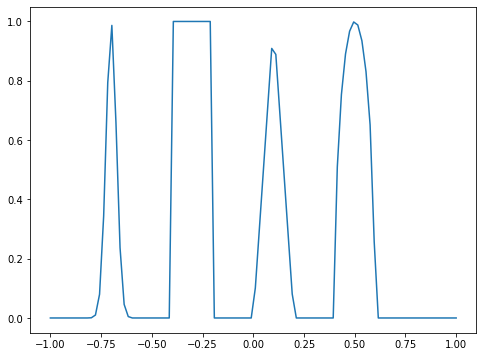

In [19]:
# Quantidade de pontos no intervalo
n=100
x=np.linspace(-1,1,n)
y=np.asarray([f(x[i]) for i in range(n)])

plt.figure(figsize=(8,6))
plt.plot(x,y)
plt.show()

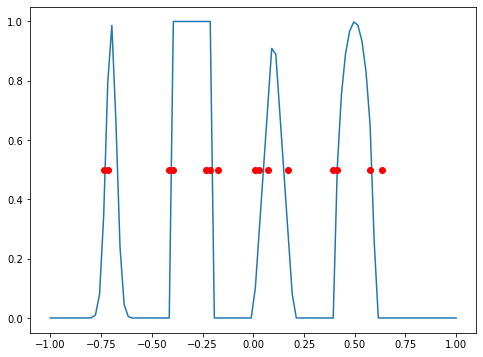

In [20]:
y_pred=tf.stack([y[i:i+5] for i in range(n-4)])
pred=tf.round(network.predict(y_pred))
plt.figure(figsize=(8,6))
plt.plot(x,y)
# Selecionando apenas os pontos com descontinuidade
x_edge=tf.gather(x[2:-2]         ,tf.squeeze(tf.where(tf.round(pred[:,0])==1)),axis=0)
y_edge=tf.gather(tf.round(pred)/2,tf.squeeze(tf.where(tf.round(pred[:,0])==1)),axis=0)

plt.plot(x_edge,y_edge,'ro')
plt.show()

# Testando a rede em imagens

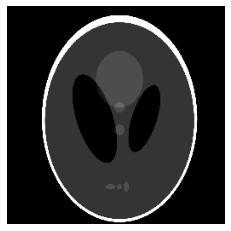

In [29]:
# O nome da imagem pode ser mudado para passar qualquer outra imagem para a a rede
img=np.asarray(imageio.imread('logan.png',pilmode='L'),dtype='float32')
len_x=img.shape[0]
len_y=img.shape[1]
plt.imshow(img,cmap='gray')
plt.axis('off')
plt.show()

In [30]:
# Pegando a lista de valores pelo eixo X
x_list=[]
for i in range(len_y-4):
    for j in range(len_x):
        x_list.append(img[j,i:i+5])

# Pegando a lista de valores pelo eixo Y
y_list=[]
for i in range(len_x-4):
    for j in range(len_y):
        y_list.append(img[i:i+5,j])

In [31]:
xy=tf.stack(x_list+y_list)
# Usar o round no código abaixo é opcional
output_pred=network.predict(xy)
#output_pred=tf.round(network.predict(xy))
output_pred_x,output_pred_y=output_pred[:len_x*(len_y-4)],output_pred[len_x*(len_y-4):]

In [32]:
new_img_x=tf.concat(tf.split(output_pred_x,len_y-4),axis=1)
new_img_y=tf.concat(tf.split(output_pred_y,len_x-4),axis=1)
new_img_x=new_img_x[2:len_x-2] # Cortando a imagem no eixo X para que ela fique do tamanho da outra
new_img_y=tf.transpose(new_img_y[2:len_y-2]) # No caso da imagem pelo eixo Y, é necessário transpor a imagem.

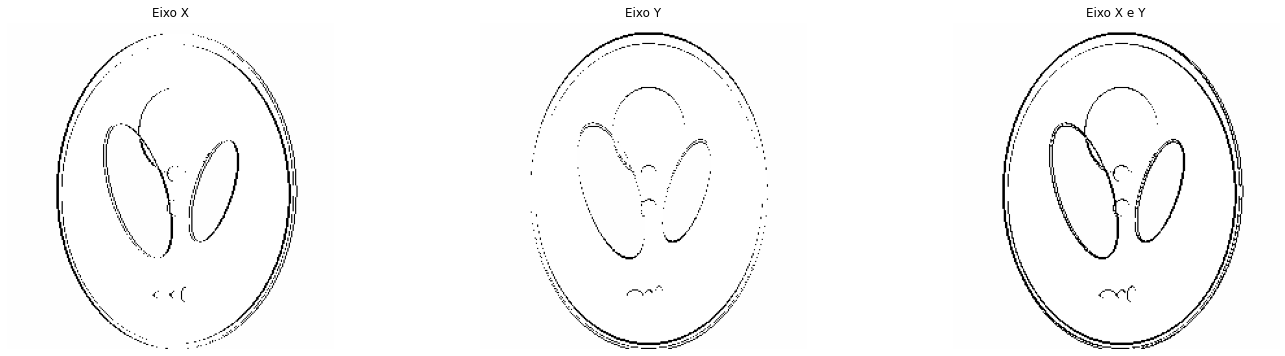

In [33]:
# Plot pelo eixo X
plt.figure(figsize=(8*3,6))
plt.subplot(1, 3, 1)
plt.title('Eixo X')
plt.axis('off')
plt.imshow(new_img_x,cmap='Greys')

# Plot pelo eixo Y
plt.subplot(1, 3, 2)
plt.title('Eixo Y')
plt.axis('off')
plt.imshow(new_img_y,cmap='Greys')

# Plot pelos dois eixos, ou seja, um ponto é considerado destínuo se ele foi considerado como descontínuo pelo eixo X ou Y
plt.subplot(1, 3, 3)
plt.title('Eixo X e Y')
plt.axis('off')
plt.imshow(tf.math.reduce_max([new_img_x,new_img_y],axis=0),cmap='Greys')

plt.show()